# スキャルピング銘柄選定のバックテスト（現実版）

## 目的
- 前営業日の大引けでEntry/Active銘柄を選定
- 翌営業日に「寄付（Open）で買い」→「大引け（Close）で売り」
- ランダム5銘柄×100株の実入りを計算
- 複数日のシミュレーションで平均リターンを検証

## 前提（現実的な条件）
- 買値 = Open（寄付）
- 売値 = Close（大引け）
- 利益 = (Close - Open) × 100株
- **Low+10%, High-10%は非現実的なので使わない**

In [40]:
import sys
from pathlib import Path

ROOT = Path.cwd().parents[1]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# matplotlib日本語対応
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']
plt.rcParams['axes.unicode_minus'] = False

## 1. データ読み込み

In [41]:
from common_cfg.paths import PARQUET_DIR

TEST_DIR = PARQUET_DIR / "test"
SCORED_PATH = TEST_DIR / "mock_screened_100stocks_scored.parquet"

df = pd.read_parquet(SCORED_PATH)

print(f"Total rows: {len(df):,}")
print(f"Unique stocks: {df['ticker'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of dates: {df['date'].nunique()}")

Total rows: 3,975
Unique stocks: 100
Date range: 2025-08-21 00:00:00 to 2025-10-20 00:00:00
Number of dates: 40


## 2. 営業日ペアの作成

In [42]:
# 営業日リスト（ソート済み）
trading_days = sorted(df['date'].unique())

# 営業日ペアを作成（前日 → 翌日）
trading_pairs = []
for i in range(len(trading_days) - 1):
    trading_pairs.append({
        'selection_date': trading_days[i],    # 選定日（前営業日大引け）
        'trading_date': trading_days[i + 1]   # 取引日（翌営業日）
    })

df_pairs = pd.DataFrame(trading_pairs)

print(f"営業日ペア数: {len(df_pairs)}")
print(f"\n最初の5ペア:")
display(df_pairs.head())
print(f"\n最後の5ペア:")
display(df_pairs.tail())

営業日ペア数: 39

最初の5ペア:


,selection_date,trading_date
0,2025-08-21,2025-08-22
1,2025-08-22,2025-08-25
2,2025-08-25,2025-08-26
3,2025-08-26,2025-08-27
4,2025-08-27,2025-08-28



最後の5ペア:


,selection_date,trading_date
34,2025-10-10,2025-10-14
35,2025-10-14,2025-10-15
36,2025-10-15,2025-10-16
37,2025-10-16,2025-10-17
38,2025-10-17,2025-10-20


## 3. バックテスト関数定義

In [43]:
def backtest_one_day(df_all, selection_date, trading_date, strategy='entry', n_stocks=5, shares=100, random_seed=None):
    """
    1日分のバックテスト（現実版: Open→Closeの値動き）
    
    Parameters:
    - df_all: 全データ
    - selection_date: 選定日（前営業日）
    - trading_date: 取引日（翌営業日）
    - strategy: 'entry' or 'active'
    - n_stocks: 投資銘柄数
    - shares: 1銘柄あたりの株数
    - random_seed: ランダムシード（再現性のため）
    
    Returns:
    - dict: バックテスト結果
    """
    # 選定日のデータ（スコアリング済み）
    df_selection = df_all[df_all['date'] == selection_date].copy()
    
    # 戦略に応じて候補銘柄を抽出
    if strategy == 'entry':
        candidates = df_selection[df_selection['entry_filter_passed']].copy()
        candidates = candidates.sort_values('entry_rank')
    else:  # active
        candidates = df_selection[df_selection['active_filter_passed']].copy()
        candidates = candidates.sort_values('active_rank')
    
    # 候補銘柄がn_stocks未満の場合
    if len(candidates) < n_stocks:
        return {
            'selection_date': selection_date,
            'trading_date': trading_date,
            'strategy': strategy,
            'candidates_count': len(candidates),
            'selected_count': 0,
            'total_profit': 0,
            'total_investment': 0,
            'return_pct': 0,
            'trades': []
        }
    
    # ランダムにn_stocks銘柄を選択
    if random_seed is not None:
        np.random.seed(random_seed)
    selected_tickers = np.random.choice(candidates['ticker'].values, size=n_stocks, replace=False)
    
    # 翌営業日のOHLCデータ取得
    df_trading = df_all[df_all['date'] == trading_date].copy()
    
    # 各銘柄の取引結果
    trades = []
    total_profit = 0
    total_investment = 0
    
    for ticker in selected_tickers:
        trading_data = df_trading[df_trading['ticker'] == ticker]
        
        if len(trading_data) == 0:
            # 翌営業日にデータがない（上場廃止等）
            continue
        
        row = trading_data.iloc[0]
        
        # 現実的な売買
        # 買値 = Open（寄付）
        buy_price = row['Open']
        
        # 売値 = Close（大引け）
        sell_price = row['Close']
        
        # 利益
        profit = (sell_price - buy_price) * shares
        investment = buy_price * shares
        return_pct = (profit / investment) * 100 if investment > 0 else 0
        
        total_profit += profit
        total_investment += investment
        
        trades.append({
            'ticker': ticker,
            'stock_name': row['stock_name'],
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'buy_price': buy_price,
            'sell_price': sell_price,
            'shares': shares,
            'profit': profit,
            'investment': investment,
            'return_pct': return_pct
        })
    
    overall_return_pct = (total_profit / total_investment) * 100 if total_investment > 0 else 0
    
    return {
        'selection_date': selection_date,
        'trading_date': trading_date,
        'strategy': strategy,
        'candidates_count': len(candidates),
        'selected_count': len(trades),
        'total_profit': total_profit,
        'total_investment': total_investment,
        'return_pct': overall_return_pct,
        'trades': trades
    }

print("バックテスト関数を定義しました（現実版: Open→Close）")

バックテスト関数を定義しました（現実版: Open→Close）


## 4. Entry戦略のバックテスト

In [44]:
# 全営業日ペアでEntry戦略をバックテスト
entry_results = []

for idx, row in df_pairs.iterrows():
    result = backtest_one_day(
        df, 
        row['selection_date'], 
        row['trading_date'], 
        strategy='entry',
        n_stocks=5,
        shares=100,
        random_seed=42 + idx  # 再現性のため
    )
    entry_results.append(result)

print(f"Entry戦略: {len(entry_results)}日分のバックテスト完了")

Entry戦略: 39日分のバックテスト完了


### 4.1 Entry戦略の全体サマリー

Entry戦略 全体サマリー:


,selection_date,trading_date,candidates_count,selected_count,total_profit,total_investment,return_pct
0,2025-08-21,2025-08-22,0,0,0,0,0.000000
1,2025-08-22,2025-08-25,8,5,-1170,384100,-0.300000
2,2025-08-25,2025-08-26,6,5,-5950,396860,-1.500000
3,2025-08-26,2025-08-27,6,5,6000,455150,1.320000
4,2025-08-27,2025-08-28,6,5,1600,315600,0.510000
5,2025-08-28,2025-08-29,7,5,-110,377400,-0.030000
6,2025-08-29,2025-09-01,7,5,-1640,412790,-0.400000
7,2025-09-01,2025-09-02,7,5,180,399260,0.050000
8,2025-09-02,2025-09-03,6,5,-520,458940,-0.110000
9,2025-09-03,2025-09-04,6,5,610,489900,0.120000



--- Entry戦略 統計 ---
総取引日数: 39
取引実行日数: 31
平均利益: ¥76
総利益: ¥2,960
平均リターン: 0.01%
勝率: 28.2%
最大利益: ¥9,050
最大損失: ¥-5,950


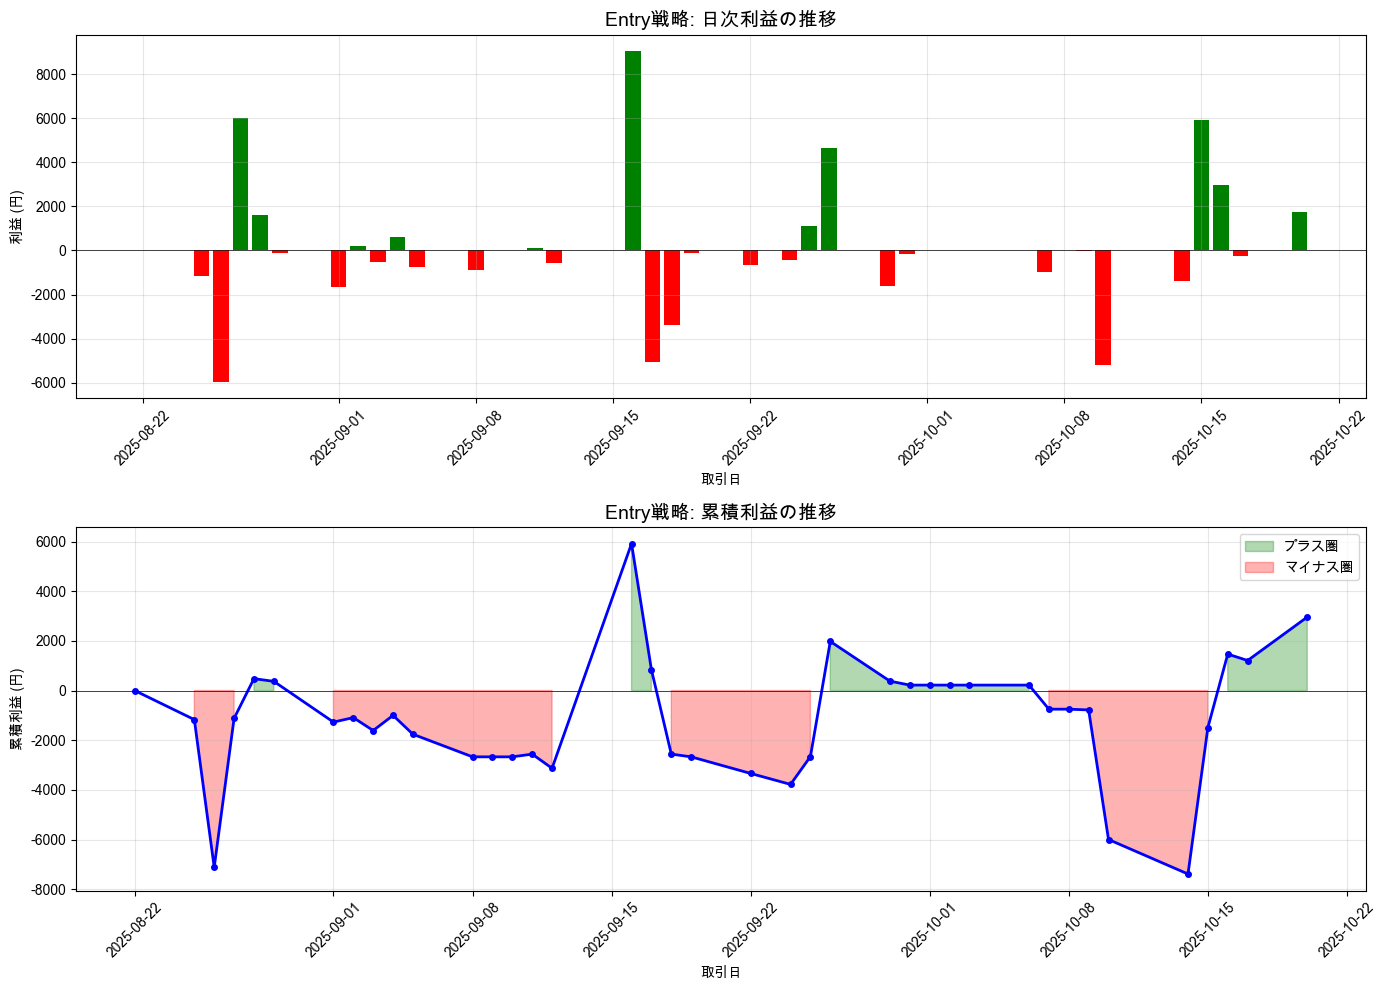

In [45]:
# サマリーデータフレーム作成
entry_summary = pd.DataFrame([{
    'selection_date': r['selection_date'],
    'trading_date': r['trading_date'],
    'candidates_count': r['candidates_count'],
    'selected_count': r['selected_count'],
    'total_profit': r['total_profit'],
    'total_investment': r['total_investment'],
    'return_pct': r['return_pct']
} for r in entry_results])

# フォーマット整形
entry_summary_display = entry_summary.copy()
entry_summary_display['selection_date'] = entry_summary_display['selection_date'].dt.strftime('%Y-%m-%d')
entry_summary_display['trading_date'] = entry_summary_display['trading_date'].dt.strftime('%Y-%m-%d')
entry_summary_display['total_profit'] = entry_summary_display['total_profit'].round(0).astype(int)
entry_summary_display['total_investment'] = entry_summary_display['total_investment'].round(0).astype(int)
entry_summary_display['return_pct'] = entry_summary_display['return_pct'].round(2)

print("Entry戦略 全体サマリー:")
display(entry_summary_display.style.set_properties(**{'text-align': 'left'}))

# 統計
print("\n--- Entry戦略 統計 ---")
print(f"総取引日数: {len(entry_summary)}")
print(f"取引実行日数: {(entry_summary['selected_count'] > 0).sum()}")
print(f"平均利益: ¥{entry_summary['total_profit'].mean():,.0f}")
print(f"総利益: ¥{entry_summary['total_profit'].sum():,.0f}")
print(f"平均リターン: {entry_summary['return_pct'].mean():.2f}%")
print(f"勝率: {(entry_summary['total_profit'] > 0).sum() / len(entry_summary) * 100:.1f}%")
print(f"最大利益: ¥{entry_summary['total_profit'].max():,.0f}")
print(f"最大損失: ¥{entry_summary['total_profit'].min():,.0f}")

# グラフ作成
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# グラフ1: 日次利益の推移
axes[0].bar(entry_summary['trading_date'], entry_summary['total_profit'], 
            color=['green' if x > 0 else 'red' if x < 0 else 'gray' for x in entry_summary['total_profit']])
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Entry戦略: 日次利益の推移', fontsize=14, fontweight='bold')
axes[0].set_xlabel('取引日')
axes[0].set_ylabel('利益 (円)')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].tick_params(axis='x', rotation=45)

# グラフ2: 累積利益の推移
cumulative_profit = entry_summary['total_profit'].cumsum()
axes[1].plot(entry_summary['trading_date'], cumulative_profit, marker='o', linewidth=2, markersize=4, color='blue')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].fill_between(entry_summary['trading_date'], cumulative_profit, 0, 
                      where=(cumulative_profit >= 0), alpha=0.3, color='green', label='プラス圏')
axes[1].fill_between(entry_summary['trading_date'], cumulative_profit, 0, 
                      where=(cumulative_profit < 0), alpha=0.3, color='red', label='マイナス圏')
axes[1].set_title('Entry戦略: 累積利益の推移', fontsize=14, fontweight='bold')
axes[1].set_xlabel('取引日')
axes[1].set_ylabel('累積利益 (円)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4.2 Entry戦略の詳細（利益が大きかった日）

In [46]:
# 利益が大きかった上位5日
top5_entry = entry_summary.nlargest(5, 'total_profit')

print("Entry戦略: 利益が大きかった上位5日")
for idx, row in top5_entry.iterrows():
    print(f"\n{'='*60}")
    print(f"選定日: {row['selection_date'].date()} → 取引日: {row['trading_date'].date()}")
    print(f"利益: ¥{row['total_profit']:,.0f} / リターン: {row['return_pct']:.2f}%")
    print(f"{'='*60}")
    
    # 該当日の取引詳細
    result = entry_results[idx]
    trades_df = pd.DataFrame(result['trades'])
    if len(trades_df) > 0:
        # フォーマット整形
        trades_display = trades_df[['ticker', 'stock_name', 'Open', 'Close', 'buy_price', 'sell_price', 'profit', 'return_pct']].copy()
        trades_display['Open'] = trades_display['Open'].round(0).astype(int)
        trades_display['Close'] = trades_display['Close'].round(0).astype(int)
        trades_display['buy_price'] = trades_display['buy_price'].round(0).astype(int)
        trades_display['sell_price'] = trades_display['sell_price'].round(0).astype(int)
        trades_display['profit'] = trades_display['profit'].round(0).astype(int)
        trades_display['return_pct'] = trades_display['return_pct'].round(2)
        display(trades_display.style.set_properties(**{'text-align': 'left'}))

Entry戦略: 利益が大きかった上位5日

選定日: 2025-09-12 → 取引日: 2025-09-16
利益: ¥9,050 / リターン: 2.23%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3556.T,リネットジャパングループ,970,1057,970,1057,8700,8.970000
1,6472.T,ＮＴＮ,342,343,342,343,150,0.440000
2,197A.T,タウンズ,560,572,560,572,1200,2.140000
3,7184.T,富山第一銀行,1306,1301,1306,1301,-500,-0.380000
4,1852.T,淺沼組,883,878,883,878,-500,-0.570000



選定日: 2025-08-26 → 取引日: 2025-08-27
利益: ¥6,000 / リターン: 1.32%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,4176.T,ココナラ,486,480,486,480,-600,-1.230000
1,197A.T,タウンズ,584,581,584,581,-300,-0.510000
2,6473.T,ジェイテクト,1412,1424,1412,1424,1300,0.920000
3,1852.T,淺沼組,840,848,840,848,800,0.950000
4,7184.T,富山第一銀行,1230,1278,1230,1278,4800,3.900000



選定日: 2025-10-14 → 取引日: 2025-10-15
利益: ¥5,900 / リターン: 1.45%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3665.T,エニグモ,399,404,399,404,500,1.250000
1,1852.T,淺沼組,824,836,824,836,1200,1.460000
2,197A.T,タウンズ,545,555,545,555,1000,1.830000
3,5852.T,アーレスティ,841,856,841,856,1500,1.780000
4,7184.T,富山第一銀行,1451,1468,1451,1468,1700,1.170000



選定日: 2025-09-25 → 取引日: 2025-09-26
利益: ¥4,640 / リターン: 1.17%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,5852.T,アーレスティ,884,888,884,888,400,0.450000
1,6472.T,ＮＴＮ,347,348,347,348,140,0.400000
2,7184.T,富山第一銀行,1310,1344,1310,1344,3400,2.600000
3,197A.T,タウンズ,561,560,561,560,-100,-0.180000
4,1852.T,淺沼組,865,873,865,873,800,0.920000



選定日: 2025-10-15 → 取引日: 2025-10-16
利益: ¥2,960 / リターン: 0.82%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,6472.T,ＮＴＮ,338,338,338,338,10,0.030000
1,6473.T,ジェイテクト,1434,1438,1434,1438,350,0.240000
2,3665.T,エニグモ,410,399,410,399,-1100,-2.680000
3,197A.T,タウンズ,557,556,557,556,-100,-0.180000
4,1852.T,淺沼組,859,897,859,897,3800,4.420000


### 4.3 Entry戦略の詳細（損失が大きかった日）

In [47]:
# 損失が大きかった下位5日
bottom5_entry = entry_summary.nsmallest(5, 'total_profit')

print("Entry戦略: 損失が大きかった下位5日")
for idx, row in bottom5_entry.iterrows():
    print(f"\n{'='*60}")
    print(f"選定日: {row['selection_date'].date()} → 取引日: {row['trading_date'].date()}")
    print(f"利益: ¥{row['total_profit']:,.0f} / リターン: {row['return_pct']:.2f}%")
    print(f"{'='*60}")
    
    # 該当日の取引詳細
    result = entry_results[idx]
    trades_df = pd.DataFrame(result['trades'])
    if len(trades_df) > 0:
        # フォーマット整形
        trades_display = trades_df[['ticker', 'stock_name', 'Open', 'Close', 'buy_price', 'sell_price', 'profit', 'return_pct']].copy()
        trades_display['Open'] = trades_display['Open'].round(0).astype(int)
        trades_display['Close'] = trades_display['Close'].round(0).astype(int)
        trades_display['buy_price'] = trades_display['buy_price'].round(0).astype(int)
        trades_display['sell_price'] = trades_display['sell_price'].round(0).astype(int)
        trades_display['profit'] = trades_display['profit'].round(0).astype(int)
        trades_display['return_pct'] = trades_display['return_pct'].round(2)
        display(trades_display.style.set_properties(**{'text-align': 'left'}))

Entry戦略: 損失が大きかった下位5日

選定日: 2025-08-25 → 取引日: 2025-08-26
利益: ¥-5,950 / リターン: -1.50%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,1852.T,淺沼組,852,843,852,843,-900,-1.060000
1,5852.T,アーレスティ,956,936,956,936,-2000,-2.090000
2,7184.T,富山第一銀行,1251,1228,1251,1228,-2300,-1.840000
3,197A.T,タウンズ,585,580,585,580,-500,-0.850000
4,6472.T,ＮＴＮ,325,322,325,322,-250,-0.770000



選定日: 2025-10-09 → 取引日: 2025-10-10
利益: ¥-5,220 / リターン: -1.45%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3665.T,エニグモ,400,395,400,395,-500,-1.250000
1,6472.T,ＮＴＮ,340,339,340,339,-70,-0.210000
2,197A.T,タウンズ,560,551,560,551,-900,-1.610000
3,6473.T,ジェイテクト,1485,1446,1485,1446,-3850,-2.590000
4,1852.T,淺沼組,825,826,825,826,100,0.120000



選定日: 2025-09-16 → 取引日: 2025-09-17
利益: ¥-5,080 / リターン: -1.27%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,6472.T,ＮＴＮ,342,342,342,342,20,0.060000
1,5852.T,アーレスティ,912,901,912,901,-1100,-1.210000
2,7184.T,富山第一銀行,1297,1266,1297,1266,-3100,-2.390000
3,1852.T,淺沼組,876,866,876,866,-1000,-1.140000
4,197A.T,タウンズ,569,570,569,570,100,0.180000



選定日: 2025-09-17 → 取引日: 2025-09-18
利益: ¥-3,400 / リターン: -0.86%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,1852.T,淺沼組,867,867,867,867,0,0.000000
1,7184.T,富山第一銀行,1275,1262,1275,1262,-1300,-1.020000
2,6472.T,ＮＴＮ,342,342,342,342,0,0.000000
3,5852.T,アーレスティ,901,883,901,883,-1800,-2.000000
4,197A.T,タウンズ,571,568,571,568,-300,-0.530000



選定日: 2025-08-29 → 取引日: 2025-09-01
利益: ¥-1,640 / リターン: -0.40%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,6472.T,ＮＴＮ,329,330,329,330,110,0.330000
1,4176.T,ココナラ,486,481,486,481,-500,-1.030000
2,6473.T,ジェイテクト,1440,1436,1440,1436,-450,-0.310000
3,7184.T,富山第一銀行,1303,1287,1303,1287,-1600,-1.230000
4,197A.T,タウンズ,570,578,570,578,800,1.400000


## 5. Active戦略のバックテスト

In [48]:
# 全営業日ペアでActive戦略をバックテスト
active_results = []

for idx, row in df_pairs.iterrows():
    result = backtest_one_day(
        df, 
        row['selection_date'], 
        row['trading_date'], 
        strategy='active',
        n_stocks=5,
        shares=100,
        random_seed=42 + idx  # 再現性のため
    )
    active_results.append(result)

print(f"Active戦略: {len(active_results)}日分のバックテスト完了")

Active戦略: 39日分のバックテスト完了


### 5.1 Active戦略の全体サマリー

Active戦略 全体サマリー:


,selection_date,trading_date,candidates_count,selected_count,total_profit,total_investment,return_pct
0,2025-08-21,2025-08-22,0,0,0,0,0.000000
1,2025-08-22,2025-08-25,6,5,3500,618600,0.570000
2,2025-08-25,2025-08-26,13,5,-5200,365700,-1.420000
3,2025-08-26,2025-08-27,5,5,-6400,518700,-1.230000
4,2025-08-27,2025-08-28,7,5,-1500,541900,-0.280000
5,2025-08-28,2025-08-29,8,5,-12800,690100,-1.850000
6,2025-08-29,2025-09-01,9,5,3700,302300,1.220000
7,2025-09-01,2025-09-02,4,0,0,0,0.000000
8,2025-09-02,2025-09-03,7,5,-6400,474200,-1.350000
9,2025-09-03,2025-09-04,9,5,1500,288500,0.520000



--- Active戦略 統計 ---
総取引日数: 39
取引実行日数: 35
平均利益: ¥-4,503
総利益: ¥-175,600
平均リターン: -0.76%
勝率: 35.9%
最大利益: ¥12,500
最大損失: ¥-40,400


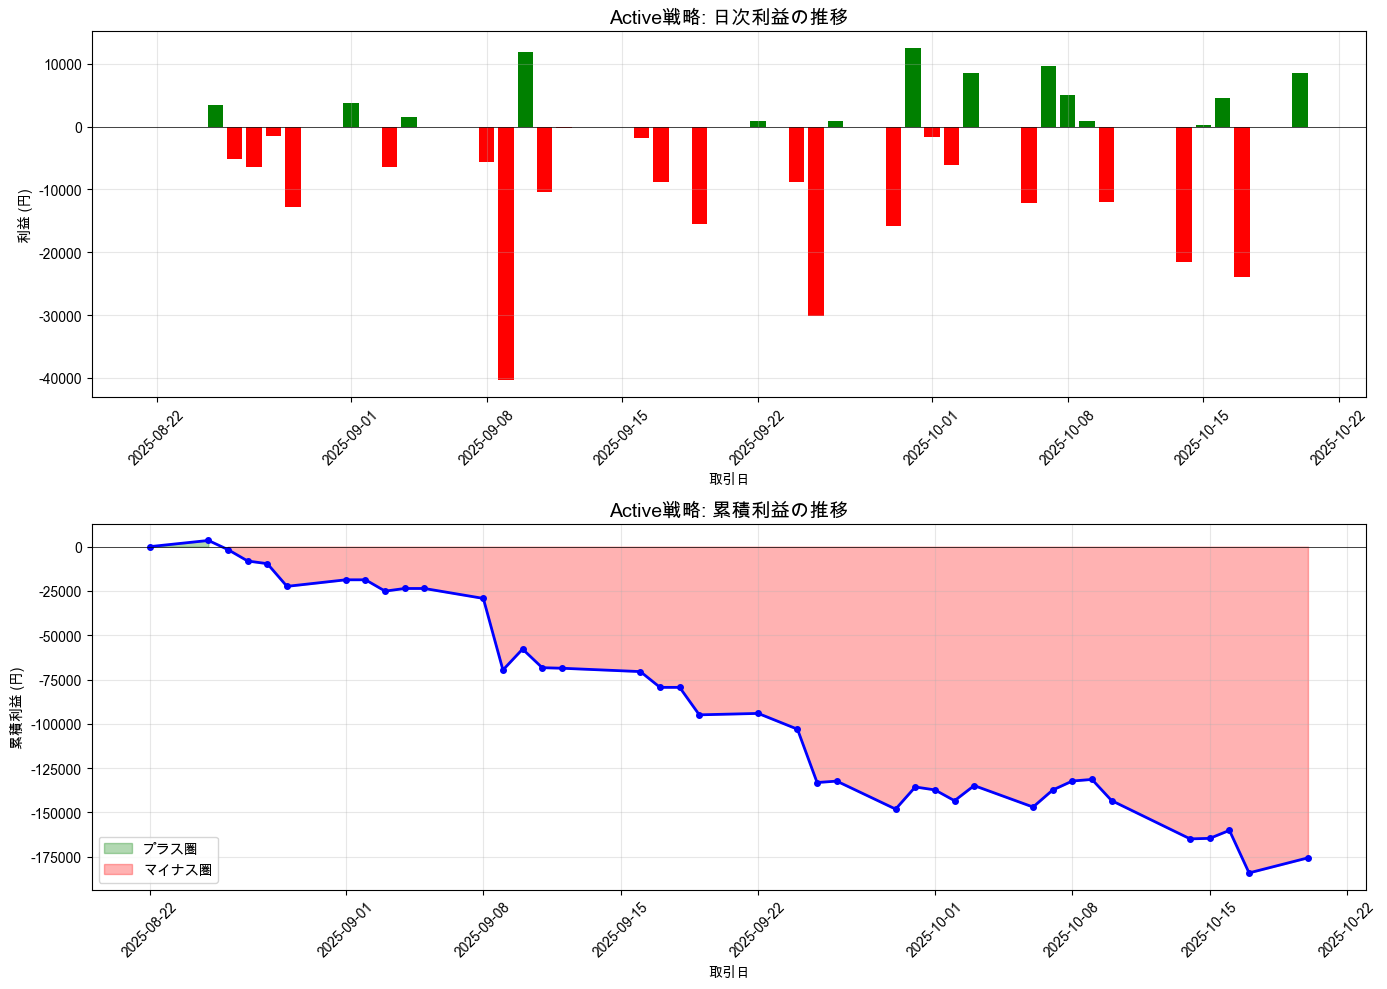

In [49]:
# サマリーデータフレーム作成
active_summary = pd.DataFrame([{
    'selection_date': r['selection_date'],
    'trading_date': r['trading_date'],
    'candidates_count': r['candidates_count'],
    'selected_count': r['selected_count'],
    'total_profit': r['total_profit'],
    'total_investment': r['total_investment'],
    'return_pct': r['return_pct']
} for r in active_results])

# フォーマット整形
active_summary_display = active_summary.copy()
active_summary_display['selection_date'] = active_summary_display['selection_date'].dt.strftime('%Y-%m-%d')
active_summary_display['trading_date'] = active_summary_display['trading_date'].dt.strftime('%Y-%m-%d')
active_summary_display['total_profit'] = active_summary_display['total_profit'].round(0).astype(int)
active_summary_display['total_investment'] = active_summary_display['total_investment'].round(0).astype(int)
active_summary_display['return_pct'] = active_summary_display['return_pct'].round(2)

print("Active戦略 全体サマリー:")
display(active_summary_display.style.set_properties(**{'text-align': 'left'}))

# 統計
print("\n--- Active戦略 統計 ---")
print(f"総取引日数: {len(active_summary)}")
print(f"取引実行日数: {(active_summary['selected_count'] > 0).sum()}")
print(f"平均利益: ¥{active_summary['total_profit'].mean():,.0f}")
print(f"総利益: ¥{active_summary['total_profit'].sum():,.0f}")
print(f"平均リターン: {active_summary['return_pct'].mean():.2f}%")
print(f"勝率: {(active_summary['total_profit'] > 0).sum() / len(active_summary) * 100:.1f}%")
print(f"最大利益: ¥{active_summary['total_profit'].max():,.0f}")
print(f"最大損失: ¥{active_summary['total_profit'].min():,.0f}")

# グラフ作成
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# グラフ1: 日次利益の推移
axes[0].bar(active_summary['trading_date'], active_summary['total_profit'], 
            color=['green' if x > 0 else 'red' if x < 0 else 'gray' for x in active_summary['total_profit']])
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Active戦略: 日次利益の推移', fontsize=14, fontweight='bold')
axes[0].set_xlabel('取引日')
axes[0].set_ylabel('利益 (円)')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].tick_params(axis='x', rotation=45)

# グラフ2: 累積利益の推移
cumulative_profit = active_summary['total_profit'].cumsum()
axes[1].plot(active_summary['trading_date'], cumulative_profit, marker='o', linewidth=2, markersize=4, color='blue')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].fill_between(active_summary['trading_date'], cumulative_profit, 0, 
                      where=(cumulative_profit >= 0), alpha=0.3, color='green', label='プラス圏')
axes[1].fill_between(active_summary['trading_date'], cumulative_profit, 0, 
                      where=(cumulative_profit < 0), alpha=0.3, color='red', label='マイナス圏')
axes[1].set_title('Active戦略: 累積利益の推移', fontsize=14, fontweight='bold')
axes[1].set_xlabel('取引日')
axes[1].set_ylabel('累積利益 (円)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 5.2 Active戦略の詳細（利益が大きかった日）

In [50]:
# 利益が大きかった上位5日
top5_active = active_summary.nlargest(5, 'total_profit')

print("Active戦略: 利益が大きかった上位5日")
for idx, row in top5_active.iterrows():
    print(f"\n{'='*60}")
    print(f"選定日: {row['selection_date'].date()} → 取引日: {row['trading_date'].date()}")
    print(f"利益: ¥{row['total_profit']:,.0f} / リターン: {row['return_pct']:.2f}%")
    print(f"{'='*60}")
    
    # 該当日の取引詳細
    result = active_results[idx]
    trades_df = pd.DataFrame(result['trades'])
    if len(trades_df) > 0:
        # フォーマット整形
        trades_display = trades_df[['ticker', 'stock_name', 'Open', 'Close', 'buy_price', 'sell_price', 'profit', 'return_pct']].copy()
        trades_display['Open'] = trades_display['Open'].round(0).astype(int)
        trades_display['Close'] = trades_display['Close'].round(0).astype(int)
        trades_display['buy_price'] = trades_display['buy_price'].round(0).astype(int)
        trades_display['sell_price'] = trades_display['sell_price'].round(0).astype(int)
        trades_display['profit'] = trades_display['profit'].round(0).astype(int)
        trades_display['return_pct'] = trades_display['return_pct'].round(2)
        display(trades_display.style.set_properties(**{'text-align': 'left'}))

Active戦略: 利益が大きかった上位5日

選定日: 2025-09-29 → 取引日: 2025-09-30
利益: ¥12,500 / リターン: 1.97%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,2371.T,カカクコム,2528,2539,2528,2539,1100,0.440000
1,8798.T,アドバンスクリエイト,310,304,310,304,-600,-1.940000
2,4176.T,ココナラ,485,484,485,484,-100,-0.210000
3,3652.T,ディジタルメディアプロフェッショナル,2261,2382,2261,2382,12100,5.350000
4,3143.T,オーウイル,746,746,746,746,0,0.000000



選定日: 2025-09-09 → 取引日: 2025-09-10
利益: ¥11,800 / リターン: 2.06%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3652.T,ディジタルメディアプロフェッショナル,2202,2297,2202,2297,9500,4.310000
1,9425.T,ＲｅＹｕｕ Ｊａｐａｎ,1091,1051,1091,1051,-4000,-3.670000
2,2743.T,ピクセルカンパニーズ,131,131,131,131,0,0.000000
3,265A.T,Ｈｍｃｏｍｍ,1391,1435,1391,1435,4400,3.160000
4,3556.T,リネットジャパングループ,917,936,917,936,1900,2.070000



選定日: 2025-10-06 → 取引日: 2025-10-07
利益: ¥9,610 / リターン: 2.68%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,2652.T,まんだらけ,338,341,338,341,300,0.890000
1,2743.T,ピクセルカンパニーズ,139,139,139,139,0,0.000000
2,8729.T,ソニーフィナンシャルグループ,158,153,158,153,-490,-3.100000
3,2291.T,福留ハム,876,842,876,842,-3400,-3.880000
4,3687.T,フィックスターズ,2081,2213,2081,2213,13200,6.340000



選定日: 2025-10-02 → 取引日: 2025-10-03
利益: ¥8,530 / リターン: 1.44%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,8729.T,ソニーフィナンシャルグループ,140,145,140,145,530,3.790000
1,3841.T,ジーダット,1315,1336,1315,1336,2100,1.600000
2,8798.T,アドバンスクリエイト,279,282,279,282,300,1.080000
3,2371.T,カカクコム,2425,2458,2425,2458,3300,1.360000
4,5253.T,カバー,1759,1782,1759,1782,2300,1.310000



選定日: 2025-10-17 → 取引日: 2025-10-20
利益: ¥8,500 / リターン: 1.59%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3687.T,フィックスターズ,1977,2065,1977,2065,8800,4.450000
1,402A.T,アクセルスペースホールディングス,732,714,732,714,-1800,-2.460000
2,4584.T,キッズウェル・バイオ,249,254,249,254,500,2.010000
3,1852.T,淺沼組,930,909,930,909,-2100,-2.260000
4,7184.T,富山第一銀行,1456,1487,1456,1487,3100,2.130000


### 5.3 Active戦略の詳細（損失が大きかった日）

In [51]:
# 損失が大きかった下位5日
bottom5_active = active_summary.nsmallest(5, 'total_profit')

print("Active戦略: 損失が大きかった下位5日")
for idx, row in bottom5_active.iterrows():
    print(f"\n{'='*60}")
    print(f"選定日: {row['selection_date'].date()} → 取引日: {row['trading_date'].date()}")
    print(f"利益: ¥{row['total_profit']:,.0f} / リターン: {row['return_pct']:.2f}%")
    print(f"{'='*60}")
    
    # 該当日の取引詳細
    result = active_results[idx]
    trades_df = pd.DataFrame(result['trades'])
    if len(trades_df) > 0:
        # フォーマット整形
        trades_display = trades_df[['ticker', 'stock_name', 'Open', 'Close', 'buy_price', 'sell_price', 'profit', 'return_pct']].copy()
        trades_display['Open'] = trades_display['Open'].round(0).astype(int)
        trades_display['Close'] = trades_display['Close'].round(0).astype(int)
        trades_display['buy_price'] = trades_display['buy_price'].round(0).astype(int)
        trades_display['sell_price'] = trades_display['sell_price'].round(0).astype(int)
        trades_display['profit'] = trades_display['profit'].round(0).astype(int)
        trades_display['return_pct'] = trades_display['return_pct'].round(2)
        display(trades_display.style.set_properties(**{'text-align': 'left'}))

Active戦略: 損失が大きかった下位5日

選定日: 2025-09-08 → 取引日: 2025-09-09
利益: ¥-40,400 / リターン: -7.04%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,9425.T,ＲｅＹｕｕ Ｊａｐａｎ,1194,1031,1194,1031,-16300,-13.650000
1,6200.T,インソース,994,993,994,993,-100,-0.100000
2,3687.T,フィックスターズ,1877,1799,1877,1799,-7800,-4.160000
3,265A.T,Ｈｍｃｏｍｍ,1530,1375,1530,1375,-15500,-10.130000
4,2743.T,ピクセルカンパニーズ,142,135,142,135,-700,-4.930000



選定日: 2025-09-24 → 取引日: 2025-09-25
利益: ¥-30,100 / リターン: -4.46%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,3556.T,リネットジャパングループ,1234,1101,1234,1101,-13300,-10.780000
1,265A.T,Ｈｍｃｏｍｍ,1280,1230,1280,1230,-5000,-3.910000
2,4054.T,日本情報クリエイト,735,726,735,726,-900,-1.220000
3,3652.T,ディジタルメディアプロフェッショナル,2776,2694,2776,2694,-8200,-2.950000
4,9425.T,ＲｅＹｕｕ Ｊａｐａｎ,730,703,730,703,-2700,-3.700000



選定日: 2025-10-16 → 取引日: 2025-10-17
利益: ¥-24,000 / リターン: -5.38%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,402A.T,アクセルスペースホールディングス,735,713,735,713,-2200,-2.990000
1,4176.T,ココナラ,394,390,394,390,-400,-1.020000
2,6200.T,インソース,903,903,903,903,0,0.000000
3,7090.T,リグア,1345,1140,1345,1140,-20500,-15.240000
4,265A.T,Ｈｍｃｏｍｍ,1082,1073,1082,1073,-900,-0.830000



選定日: 2025-10-10 → 取引日: 2025-10-14
利益: ¥-21,600 / リターン: -2.17%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,6807.T,日本航空電子工業,2475,2422,2475,2422,-5300,-2.140000
1,7793.T,イメージ・マジック,1619,1567,1619,1567,-5200,-3.210000
2,3687.T,フィックスターズ,1920,1859,1920,1859,-6100,-3.180000
3,5256.T,Ｆｕｓｉｃ,2782,2710,2782,2710,-7200,-2.590000
4,6570.T,共和コーポレーション,1165,1187,1165,1187,2200,1.890000



選定日: 2025-09-26 → 取引日: 2025-09-29
利益: ¥-15,800 / リターン: -3.82%


,ticker,stock_name,Open,Close,buy_price,sell_price,profit,return_pct
0,2743.T,ピクセルカンパニーズ,151,145,151,145,-600,-3.970000
1,3652.T,ディジタルメディアプロフェッショナル,2377,2255,2377,2255,-12200,-5.130000
2,3665.T,エニグモ,439,425,439,425,-1400,-3.190000
3,4176.T,ココナラ,499,480,499,480,-1900,-3.810000
4,9425.T,ＲｅＹｕｕ Ｊａｐａｎ,670,673,670,673,300,0.450000


## 6. Entry vs Active 比較

In [52]:
print("="*60)
print("Entry vs Active 比較")
print("="*60)

comparison = pd.DataFrame({
    '戦略': ['Entry', 'Active'],
    '総利益': [entry_summary['total_profit'].sum(), active_summary['total_profit'].sum()],
    '平均利益/日': [entry_summary['total_profit'].mean(), active_summary['total_profit'].mean()],
    '平均リターン%': [entry_summary['return_pct'].mean(), active_summary['return_pct'].mean()],
    '勝率%': [
        (entry_summary['total_profit'] > 0).sum() / len(entry_summary) * 100,
        (active_summary['total_profit'] > 0).sum() / len(active_summary) * 100
    ],
    '最大利益': [entry_summary['total_profit'].max(), active_summary['total_profit'].max()],
    '最大損失': [entry_summary['total_profit'].min(), active_summary['total_profit'].min()]
})

display(comparison.style.set_properties(**{'text-align': 'left'}))

print("\n--- 結論 ---")
if entry_summary['total_profit'].sum() > active_summary['total_profit'].sum():
    print("✅ Entry戦略の方が総利益が大きい")
else:
    print("✅ Active戦略の方が総利益が大きい")

if entry_summary['return_pct'].mean() > active_summary['return_pct'].mean():
    print("✅ Entry戦略の方が平均リターンが高い")
else:
    print("✅ Active戦略の方が平均リターンが高い")

Entry vs Active 比較


,戦略,総利益,平均利益/日,平均リターン%,勝率%,最大利益,最大損失
0,Entry,2960.000000,75.897436,0.012421,28.205128,9050.000000,-5950.000000
1,Active,-175600.000000,-4502.564103,-0.758735,35.897436,12500.000000,-40400.000000



--- 結論 ---
✅ Entry戦略の方が総利益が大きい
✅ Entry戦略の方が平均リターンが高い
